In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from umap import UMAP

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu


/home/qlyu/mambaforge/envs/bbbroutine/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sample = 'P28NR'
outdir_fig = "/scr/qlyu/projects/v1/figures"

In [3]:
adata = anndata.read(f"../../data/cheng21_cell_scrna/organized/{sample}.h5ad")
genes = adata.var.index.values
adata

AnnData object with n_obs × n_vars = 23930 × 53801
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'sample_new', 'layer', 'Type', 'Subclass'

In [4]:
adata = adata[adata.obs['Subclass'] == 'L2/3']
types = adata.obs['Type'].values
samps = adata.obs['sample'].values
adata

View of AnnData object with n_obs × n_vars = 4044 × 53801
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'sample_new', 'layer', 'Type', 'Subclass'

In [5]:
# use those 286 genes
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_sel = df['gene'].astype(str).values
genes_grp = df['P17on'].astype(str).values
assert len(genes_sel) == len(np.unique(genes_sel))

gi = basicu.get_index_from_array(genes, genes_sel)
assert np.all(genes_sel != -1)

# CP10k for single cells
cov = np.array(adata.X.sum(axis=1))
counts = np.array(adata.X[:,gi].todense())
norm = counts/cov*1e4
lognorm = np.log10(norm+1)
zlognorm = zscore(lognorm, axis=0) 

In [6]:
zlognorm = np.nan_to_num(zlognorm, 0)

In [7]:
gene_types, gene_type_counts = np.unique(genes_grp, return_counts=True)
gene_types, gene_type_counts

(array(['A', 'B', 'C'], dtype=object), array([122,  35, 129]))

In [8]:
pca = PCA(n_components=50)
pcs = pca.fit_transform(zlognorm)
ucs = UMAP(n_components=2, n_neighbors=50).fit_transform(pcs)

In [9]:
# fix pc1 to make sure a < c:
pc1 = pcs[:,0]
pc_types, unq_types = basicu.group_mean(pc1.reshape(-1,1), types)
a = pc_types[0,0]
c = pc_types[-1,0]
if a > c:
    pcs[:,0] = -pcs[:,0]

In [10]:
res = pd.DataFrame(pcs, columns=np.char.add("PC", ((1+np.arange(pcs.shape[1])).astype(str))))
res['type'] = types
res['samp'] = samps
res['umap1'] = ucs[:,0]
res['umap2'] = ucs[:,1]

Text(0, 0.5, 'explained var')

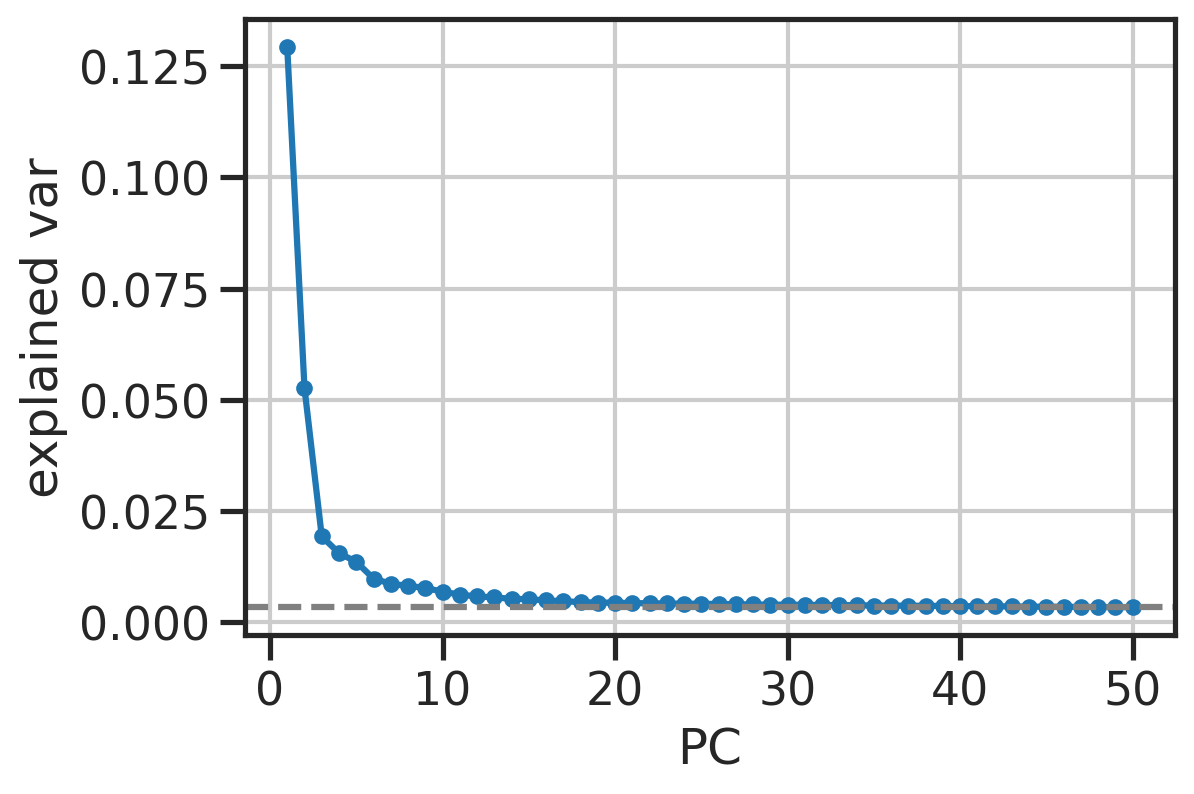

In [11]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.arange(len(pca.explained_variance_ratio_))+1, pca.explained_variance_ratio_, '-o', markersize=5)
ax.axhline(1/lognorm.shape[1], linestyle='--', color='gray')
ax.set_xlabel('PC')
ax.set_ylabel('explained var')

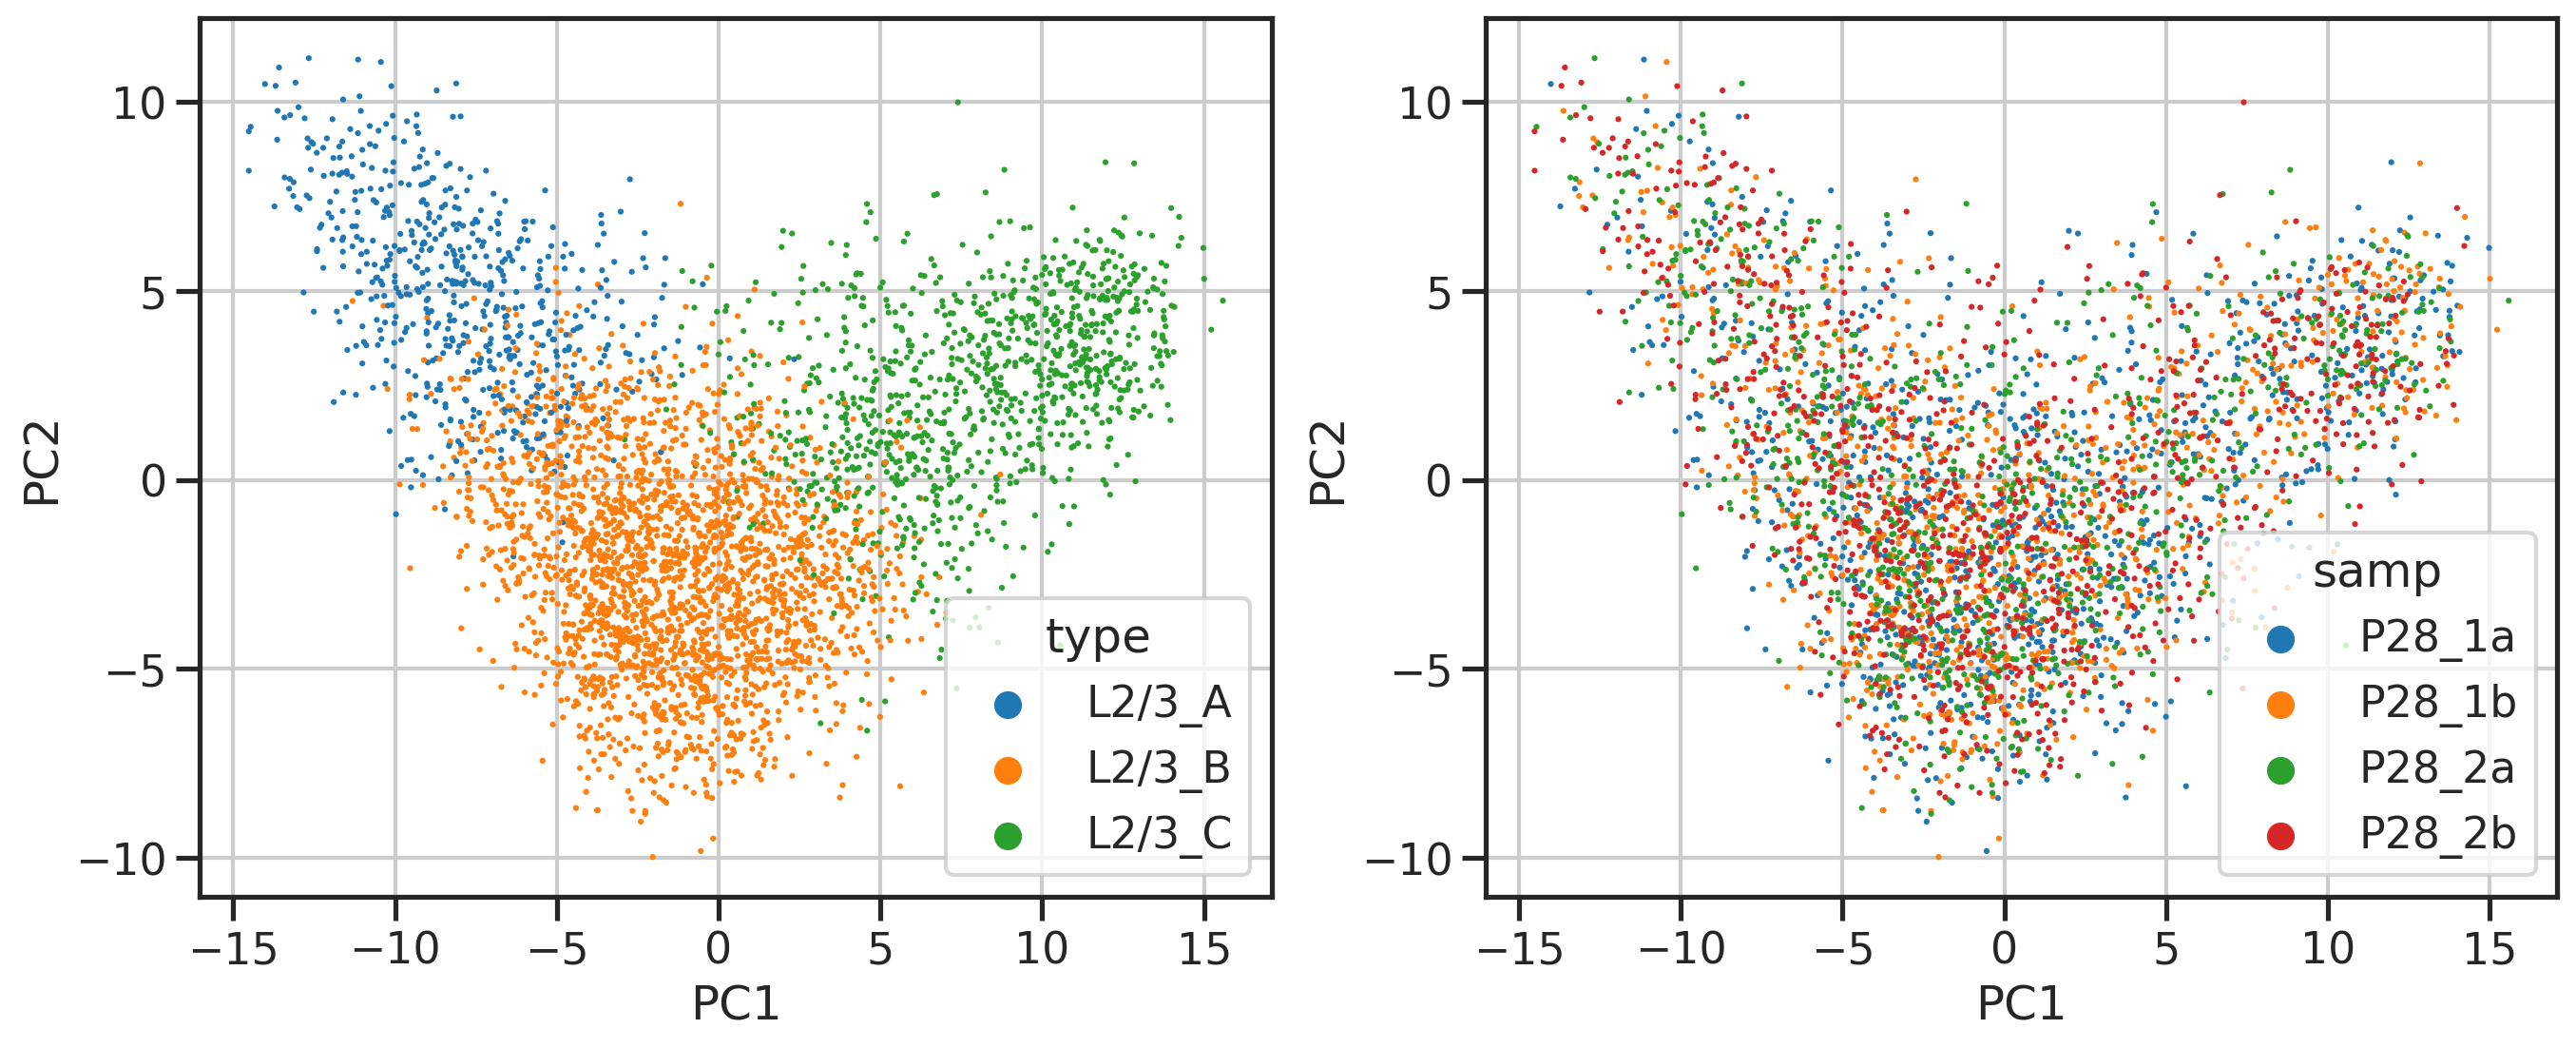

In [12]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='PC1', y='PC2', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='PC1', y='PC2', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

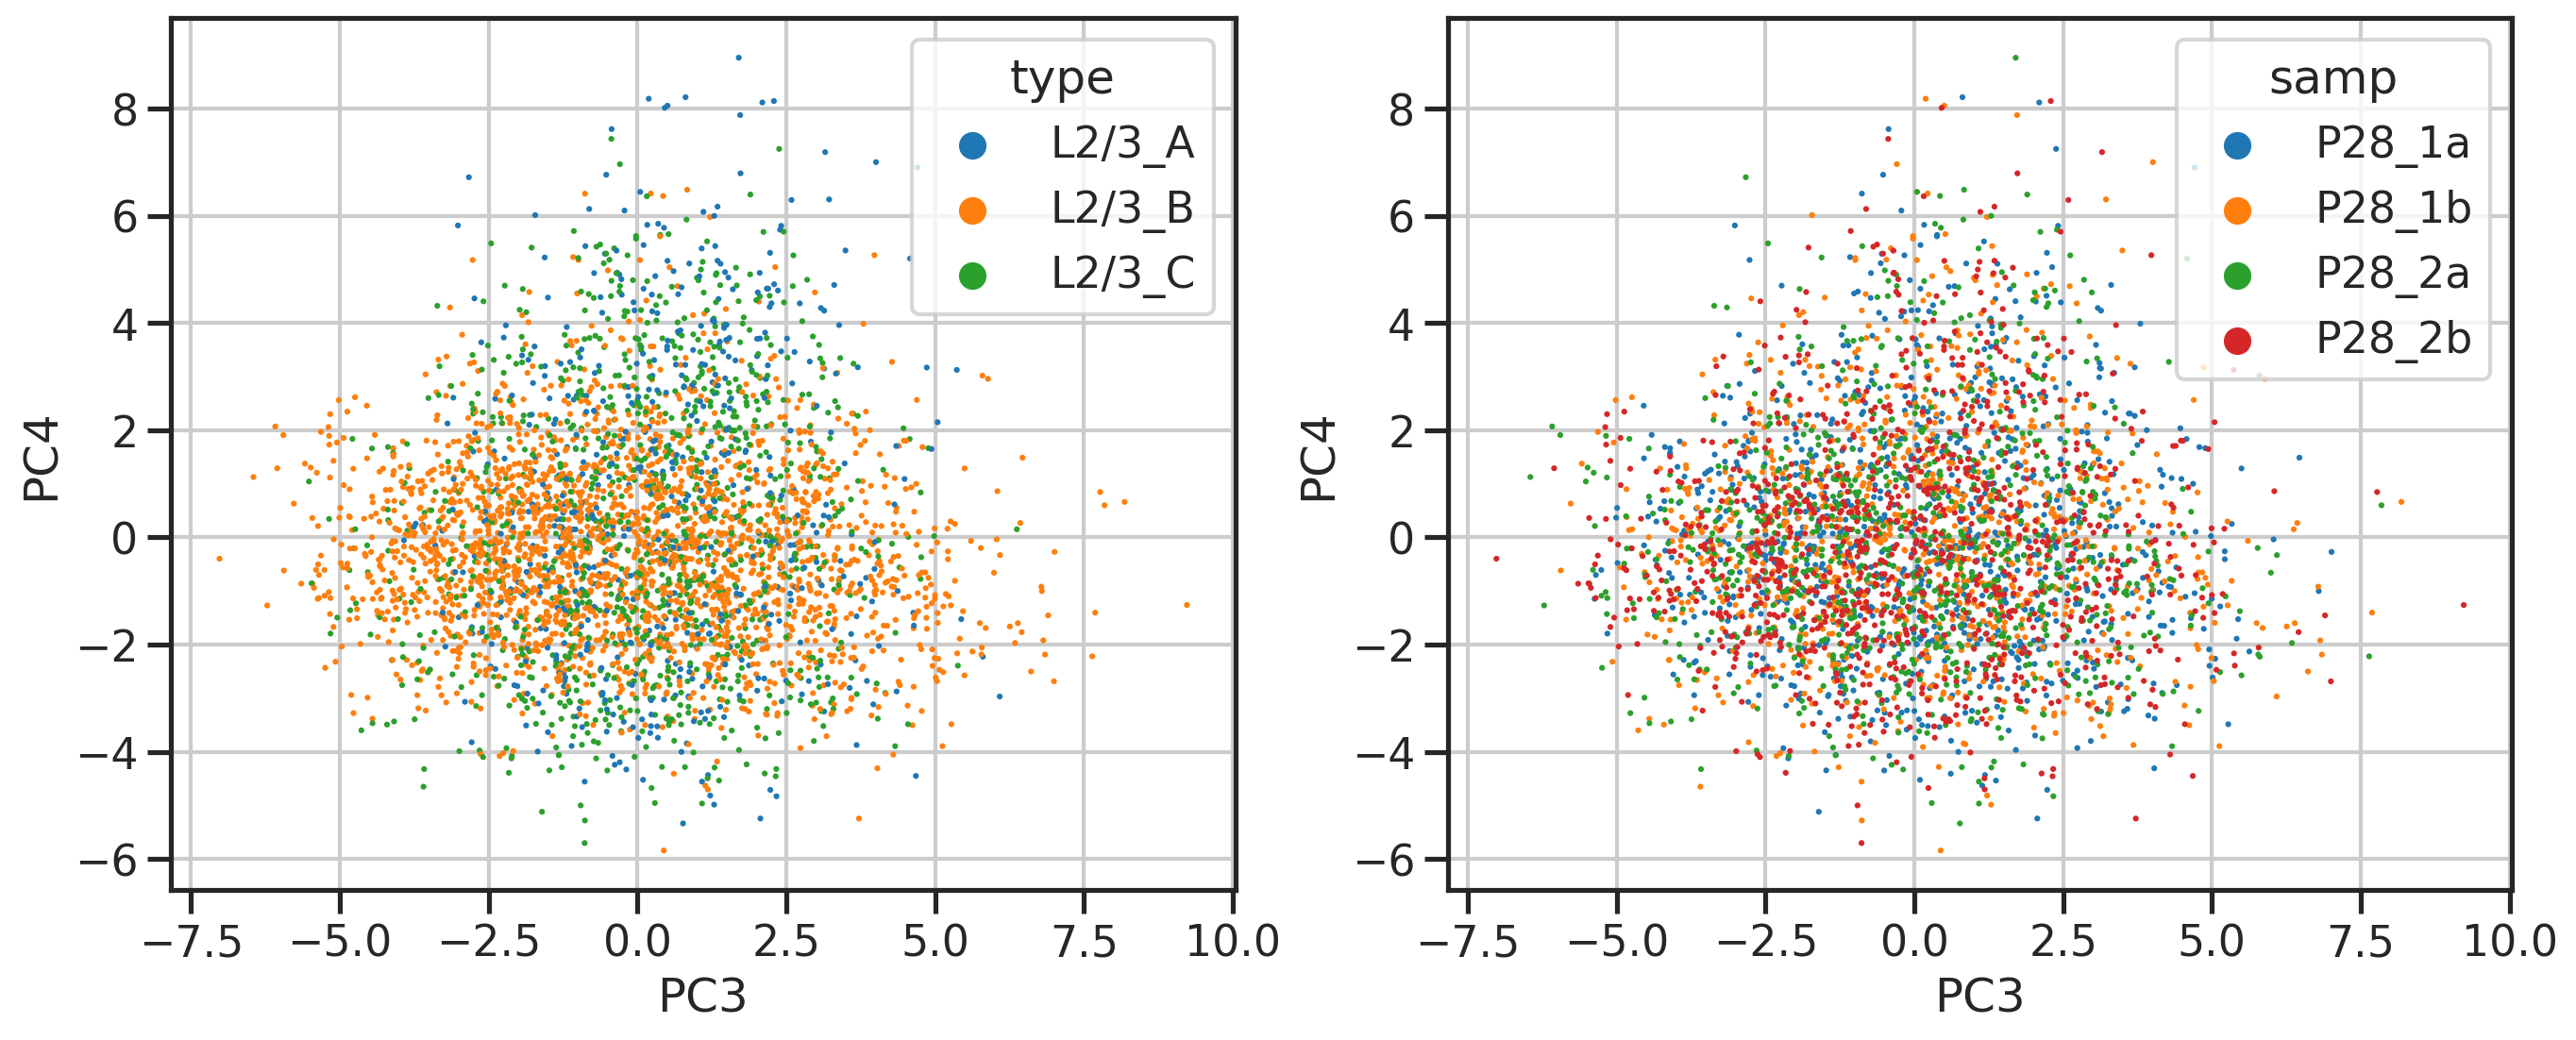

In [13]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='PC3', y='PC4', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='PC3', y='PC4', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

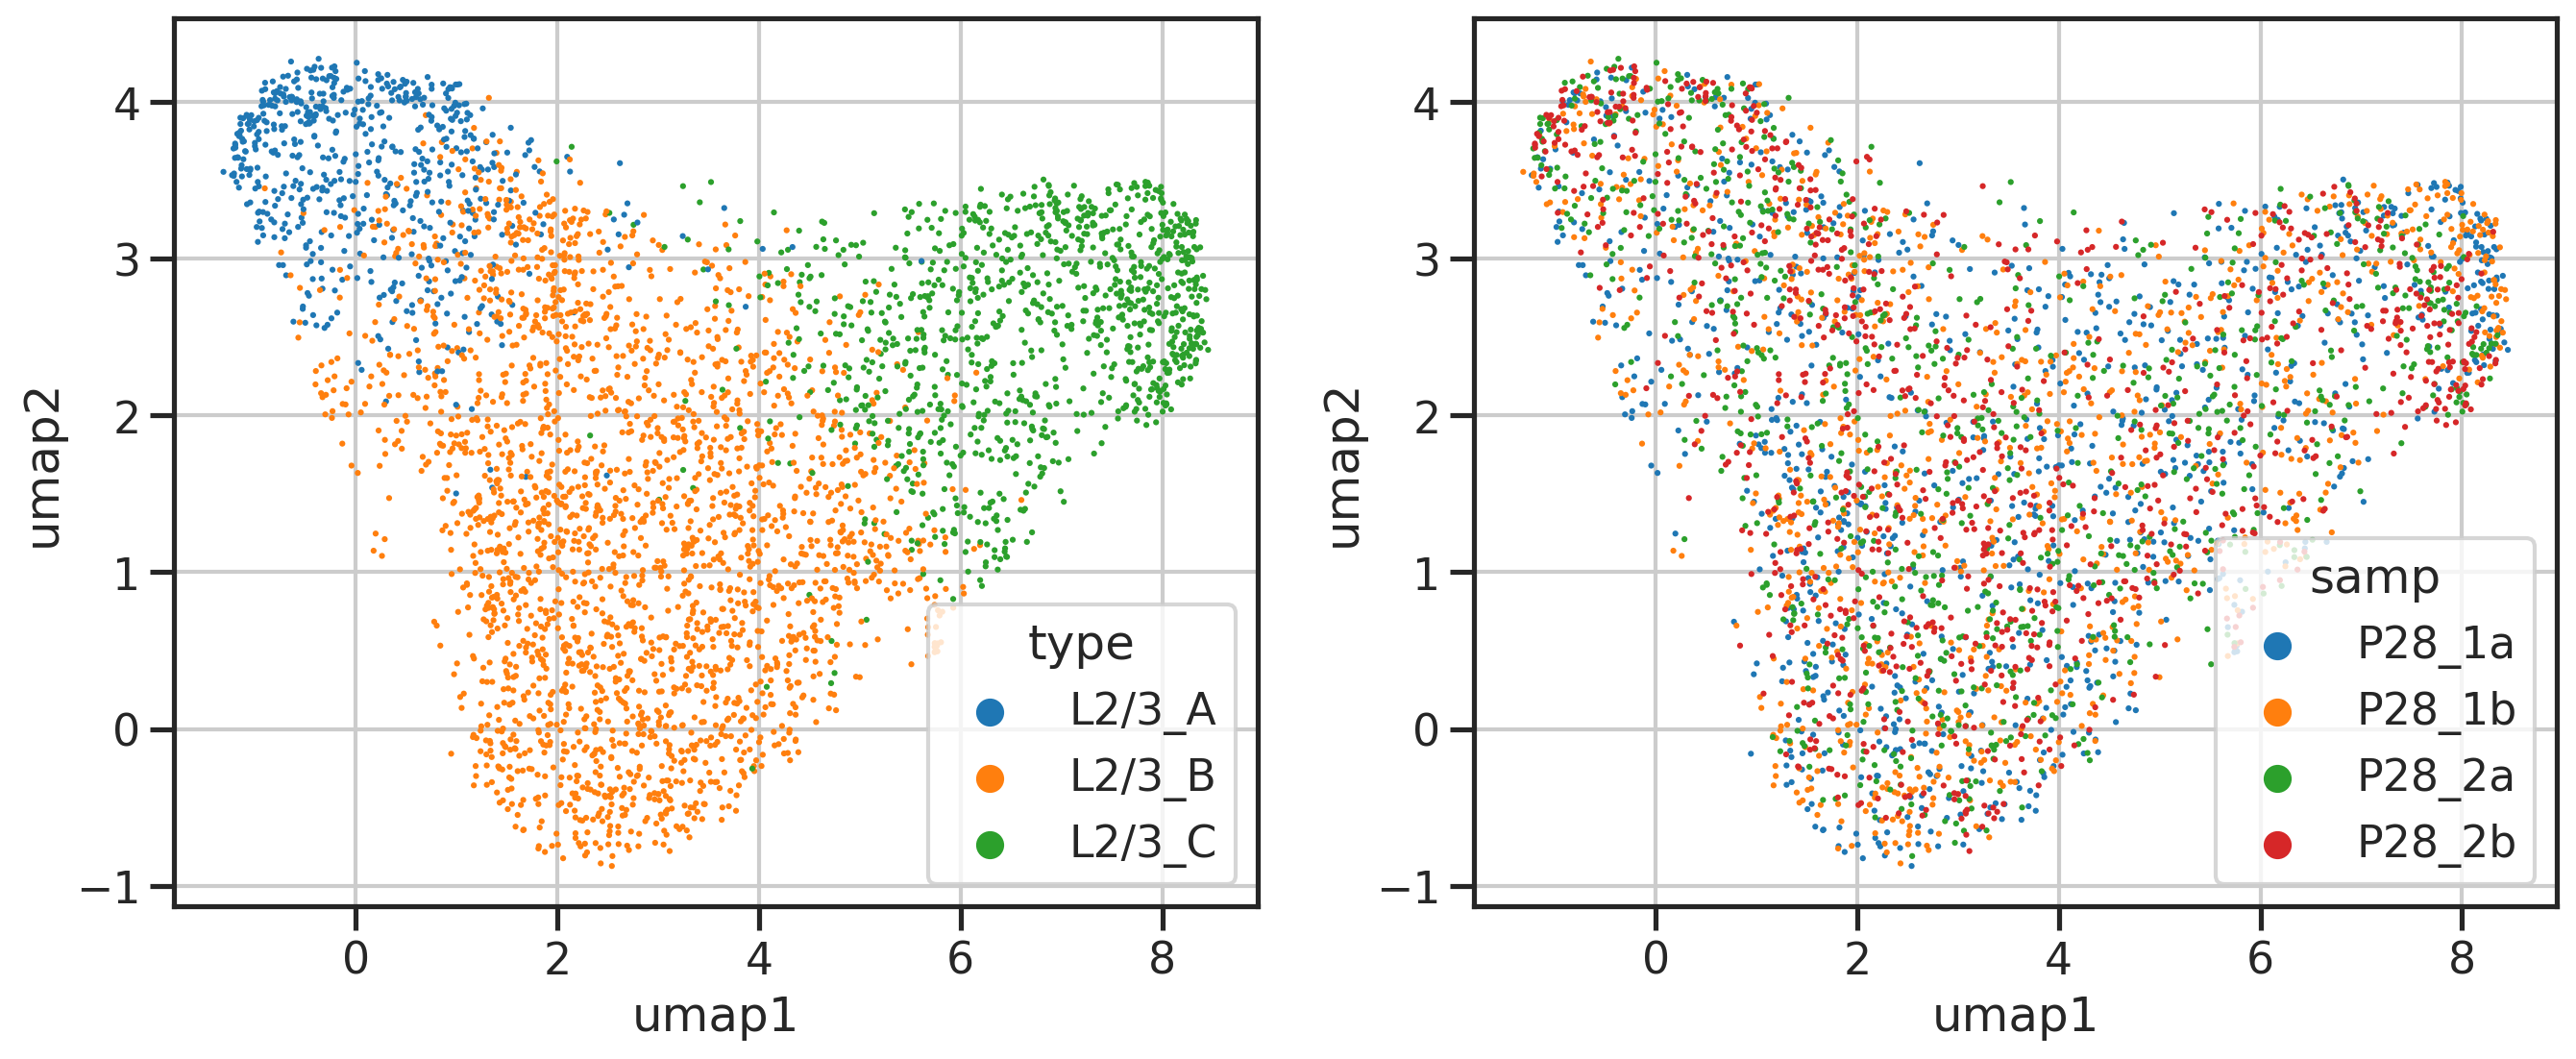

In [14]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='umap1', y='umap2', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='umap1', y='umap2', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

# heatmap

In [15]:
choices1 = sns.color_palette('tab10', 3)
choices1

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)]

In [16]:
choices2 = sns.color_palette('tab20', 20)
choices2

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [17]:
my_colors = tuple(list(choices1)) #('C0', 'C1', 'C2')
cmap_d1 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

my_colors = tuple(list(choices2[6:8])+list(choices2[14:16]))
cmap_d2 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

ncell, ngene = zlognorm.shape

In [18]:
adata.obsm['X_pca'] = pcs
sc.pp.neighbors(adata, n_neighbors=50, use_rep='X_pca')
sc.tl.diffmap(adata)
adata.uns['iroot'] = np.argmin(pcs[:,0])
sc.tl.dpt(adata)
res['ptime'] = adata.obs['dpt_pseudotime'].values

In [19]:
cellidx = np.argsort(res['ptime'].values)

# # gene ptime
# weights = ((lognorm+1e-10)/(lognorm.sum(axis=0)+1e-10))
# gptime  = res['ptime'].values.dot(weights)
# geneidx = np.argsort(gptime)

# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
geneidx2 = np.argsort(gpt)

# check pseudotime (and diff map)

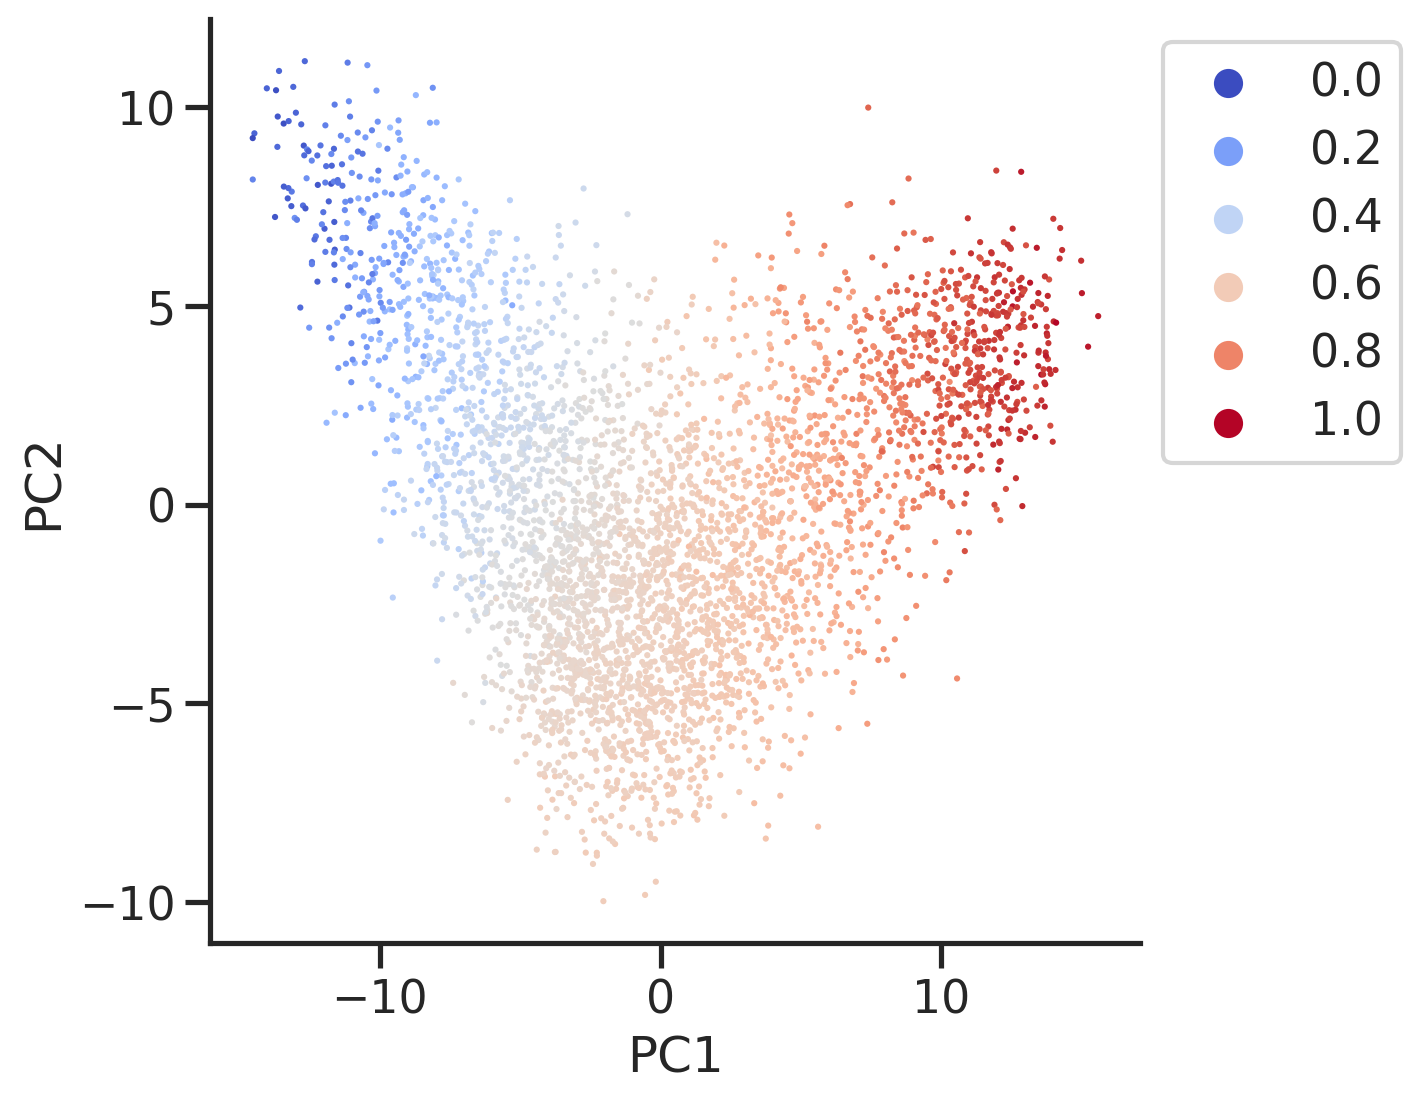

In [20]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=res, 
                x='PC1',
                y='PC2',
                hue='ptime',
                # hue_order=np.sort(adata.obs['cluster'].unique()),
                edgecolor='none',
                s=5,
                ax=ax,
                palette='coolwarm',
               )
# ax.set_xlabel(f'PC1 ({pca_v[0]*100:.1f}% var)')
# ax.set_ylabel(f'PC2 ({pca_v[1]*100:.1f}% var)')

ax.legend(bbox_to_anchor=(1,1), loc='upper left')
sns.despine(ax=ax)
ax.grid(False)
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
plt.show()

03-28 14:05:36 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


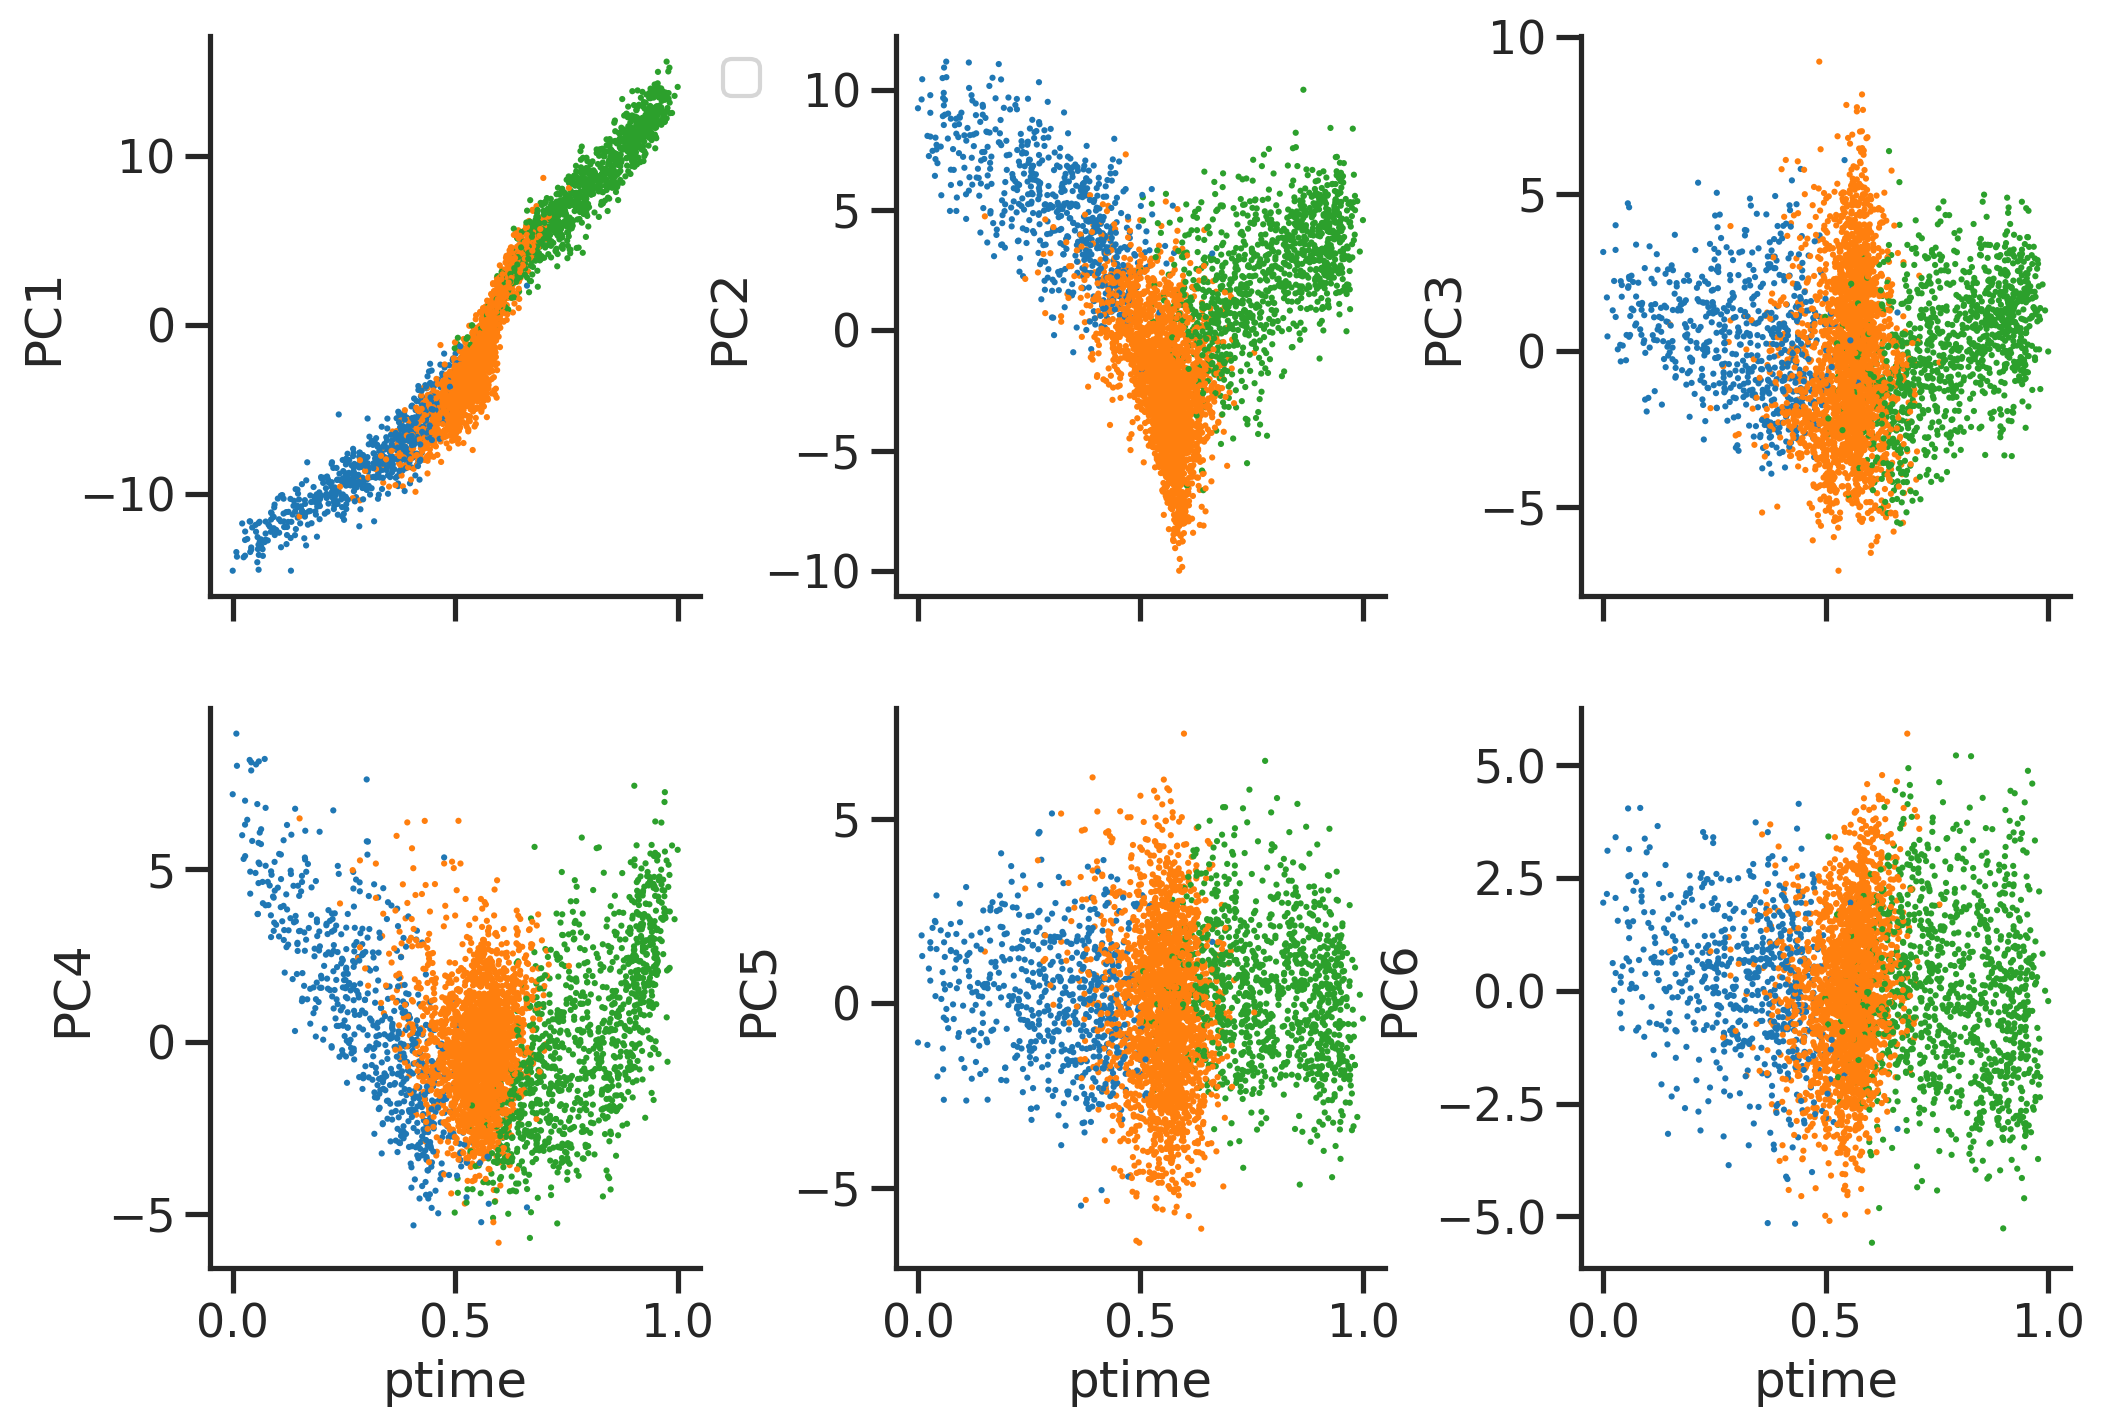

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(4*3,4*2), sharex=True)
for i, ax in enumerate(axs.flat):
    sns.scatterplot(data=res, 
                    x='ptime',
                    y=f'PC{i+1}',
                    hue='type',
                    edgecolor='none',
                    s=5,
                    ax=ax,
                    legend=False,
                   )
    ax.grid(False)
    sns.despine(ax=ax)
axs.flat[0].legend(bbox_to_anchor=(1,1), loc='upper left')
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
fig.subplots_adjust(wspace=0.4)
plt.show()

03-28 14:05:41 - maxp pruned
03-28 14:05:42 - cmap pruned
03-28 14:05:42 - kern dropped
03-28 14:05:42 - post pruned
03-28 14:05:42 - FFTM dropped
03-28 14:05:42 - GPOS pruned
03-28 14:05:42 - GSUB pruned
03-28 14:05:42 - name pruned
03-28 14:05:42 - glyf pruned
03-28 14:05:42 - Added gid0 to subset
03-28 14:05:42 - Added first four glyphs to subset
03-28 14:05:42 - Closing glyph list over 'GSUB': 35 glyphs before
03-28 14:05:42 - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'G', 'N', 'P', 'R', 'a', 'c', 'e', 'eight', 'five', 'four', 'g', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'space', 't', 'three', 'two', 'y', 'z', 'zero']
03-28 14:05:42 - Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 27, 36, 37, 38, 42, 49, 51, 53, 68, 70, 72, 74, 78, 79, 80, 81, 82, 83, 85, 86, 87, 92, 93, 3228]
03-28 14:05:42 - Closed glyph list over 'GSUB': 35 glyphs after
03-28 14:05:42 - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'G', 'N', 'P', 'R'

saved the figure to: /scr/qlyu/projects/v1/figures/heatmap_P28NR_v4_2023-03-28.pdf


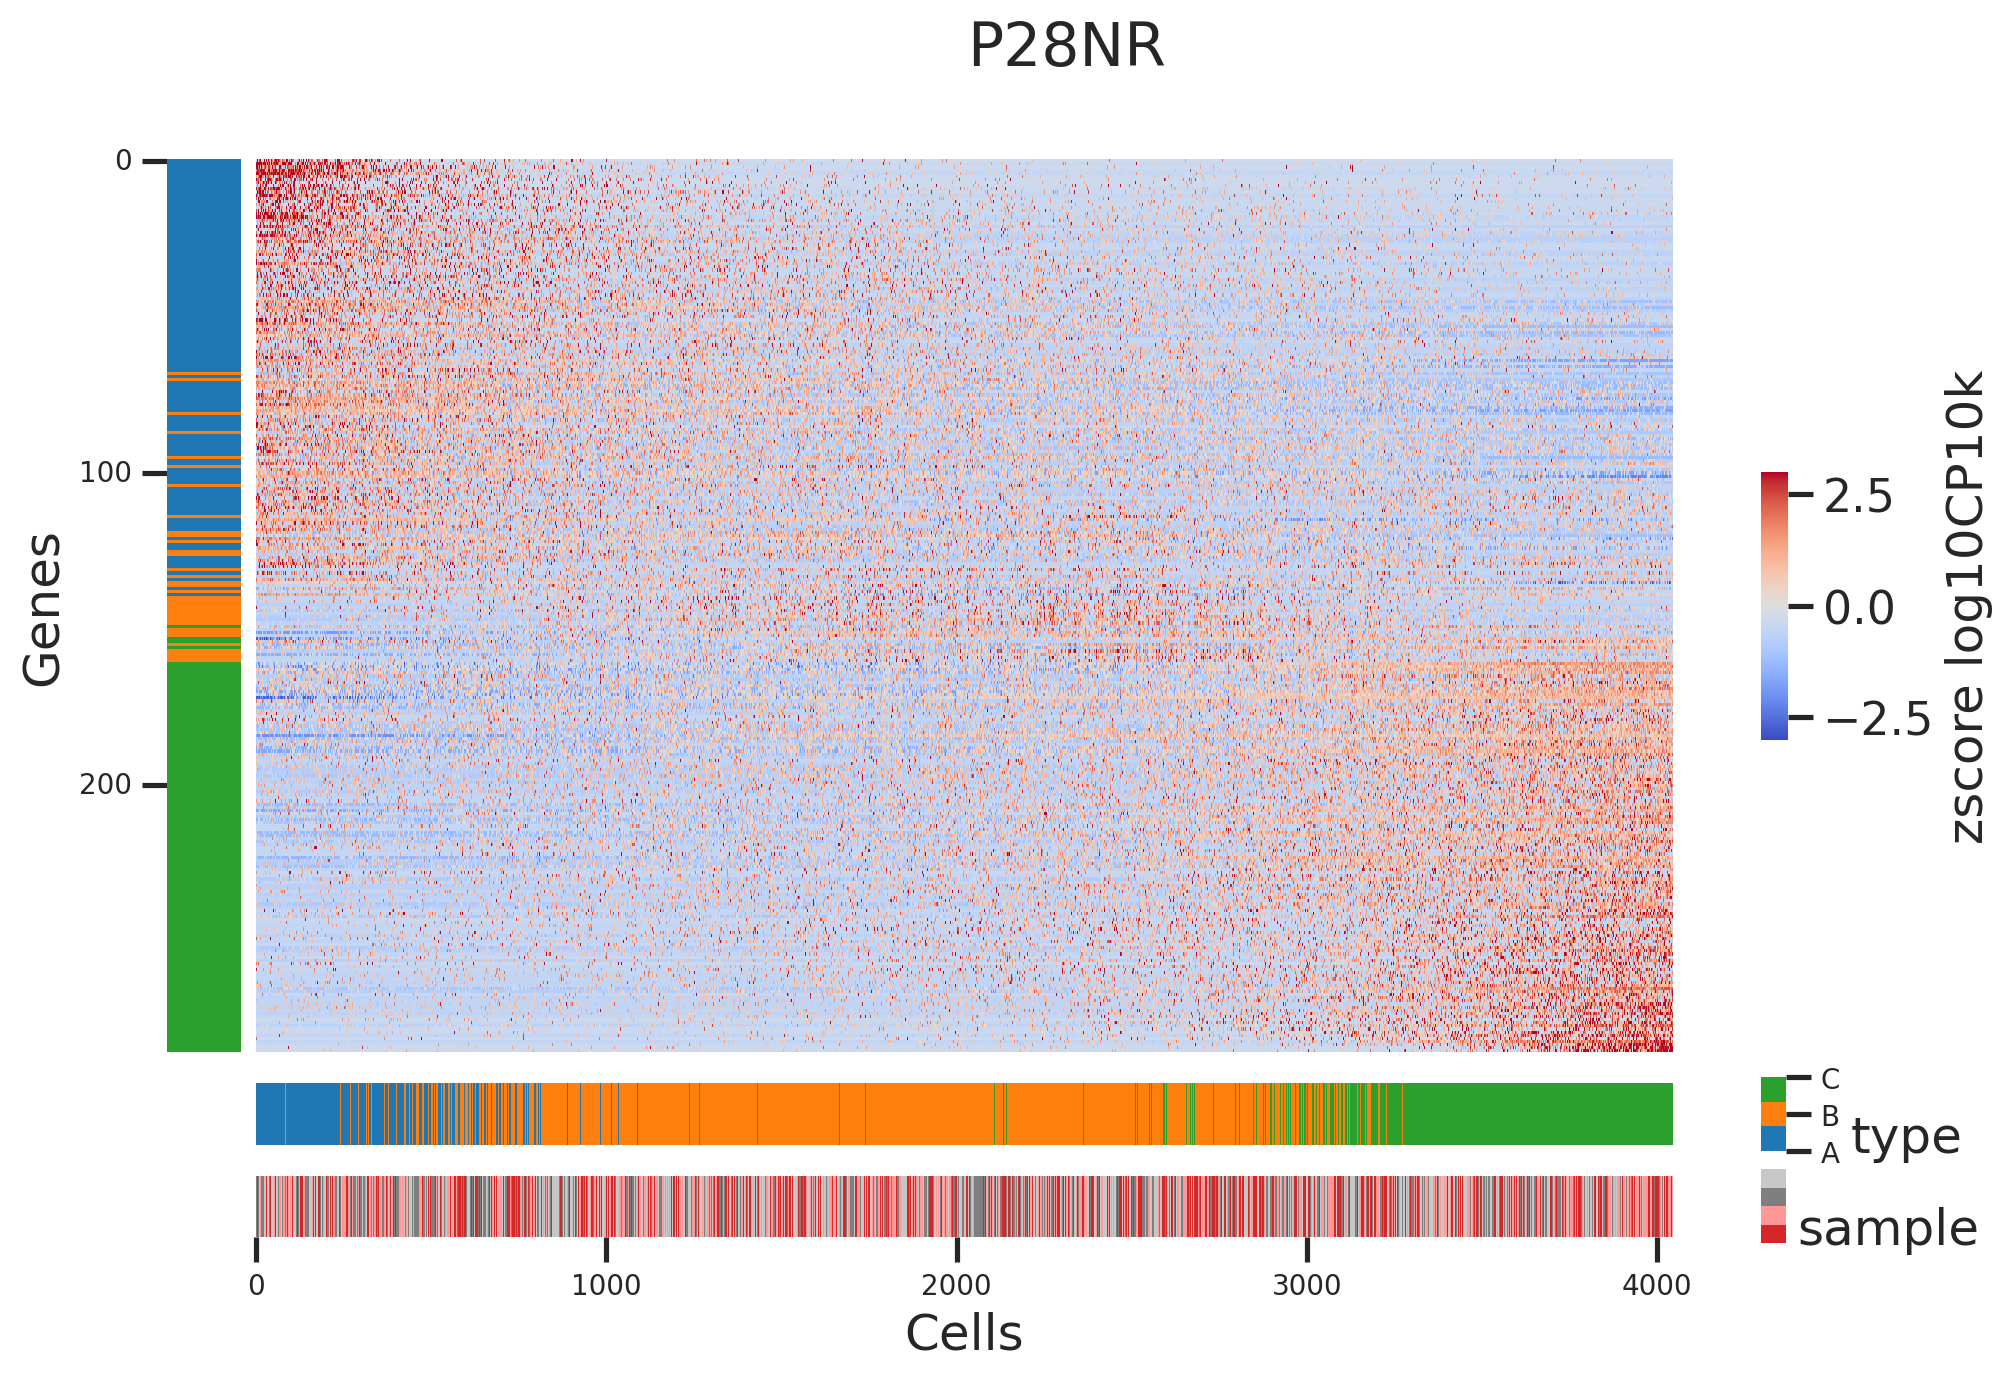

In [22]:

mosaic = ("B"+"A"*20+"\n")*10 + ("."+"C"*20+"\n") + ("."+"D"*20+"\n")
# print(mosaic)

fig, axdict = plt.subplot_mosaic(mosaic, figsize=(12,7))
ax = axdict['A']
sns.heatmap(zlognorm[cellidx][:,geneidx2].T,
            xticklabels=False,
            yticklabels=False,
            cbar_kws=dict(shrink=0.3, label='zscore log10CP10k', aspect=10),
            center=0,
            vmax=3,
            vmin=-3,
            cmap='coolwarm',
            rasterized=True,
            ax=ax,
           )

ax = axdict['B']
sns.heatmap(pd.factorize(genes_grp[geneidx2], sort=True)[0].reshape(-1,1), 
            xticklabels=False,
            yticklabels=100,
            cmap=cmap_d1,
            cbar=False,
            rasterized=True,
            ax=ax, 
           )
ax.set_ylabel('Genes')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

ax = axdict['C']
sns.heatmap(pd.factorize(types[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=False,
            yticklabels=False,
            cmap=cmap_d1,
            cbar_kws=dict(ticks=[0,1,2], shrink=1.2, aspect=3, label='type'),
            rasterized=True,
            ax=ax, 
           )
fig.axes[-1].set_yticklabels(['A','B','C'], fontsize=10)
fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')

ax = axdict['D']
sns.heatmap(pd.factorize(samps[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=1000,
            yticklabels=False,
            cmap=cmap_d2,
            cbar_kws=dict(ticks=[], shrink=1.2, aspect=3, label='sample'),
            rasterized=True,
            ax=ax, 
           )
ax.set_xlabel('Cells')
fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

fig.subplots_adjust(hspace=0.5)
fig.suptitle(sample)
powerplots.savefig_autodate(fig, os.path.join(outdir_fig, f'heatmap_{sample}_v4.pdf'))
plt.show()

In [23]:
# save ptime info

In [24]:
res.index = adata.obs.index
res

PC1       PC2       PC3       PC4  \
AAACCCAGTTCTCTCG-1-P28_1a-P28   1.146197  5.233500 -2.200451 -3.930217   
AAACGAAAGCAAGGAA-1-P28_1a-P28  -0.518837 -6.410211  1.400165  0.046731   
AAACGCTAGTTTGCTG-1-P28_1a-P28   3.927249  3.636246 -1.236637 -2.775061   
AAACGCTCAACCGTGC-1-P28_1a-P28  11.051399  6.327102  2.314033  1.087070   
AAAGAACAGCGATGGT-1-P28_1a-P28  -3.685992 -2.021548 -0.263423 -2.174867   
...                                  ...       ...       ...       ...   
TTTCGATGTAACAAGT-1-P28_2b-P28  -6.097852 -2.068505 -1.277921  1.154793   
TTTCGATTCCGCTAGG-1-P28_2b-P28  -3.879921  0.587715  1.842610 -2.062828   
TTTGACTTCAGCTTGA-1-P28_2b-P28   1.520208 -1.121137 -0.979946 -1.053952   
TTTGATCTCTTTGCTA-1-P28_2b-P28   0.086317 -1.396976  2.496928 -1.632108   
TTTGTTGCAAGTGATA-1-P28_2b-P28  -4.506055 -4.132748  0.456263 -0.314469   

                                    PC5       PC6       PC7       PC8  \
AAACCCAGTTCTCTCG-1-P28_1a-P28 -0.111922  1.029476  2.120738 -0.133120   
AAACGAAAGCAAGGAA-1-P28_1a-P28 -0.776028 -3.155421 -0.413253 -1.502912   
AAACGCTAGTTTGCTG-1-P28_1a-P28 -0.591087 -0.833479 -0.331241 -0.631949   
AAACGCTCAACCGTGC-1-P28_1a-P28 -1.128625 -2.499452  1.621848 -0.682862   
AAAGAACAGCGATGGT-1-P28_1a-P28  0.280566 -1.501202  1.067050 -2.433449   
...                                 ...       ...       ...       ...   
TTTCGATGTAACAAGT-1-P28_2b-P28 -1.460764  0.536935  0.480625 -1.756502   
TTTCGATTCCGCTAGG-1-P28_2b-P28  1.118867 -1.963338 -1.663969  1.985066   
TTTGACTTCAGCTTGA-1-P28_2b-P28  0.388502 -1.972154 -1.373765  0.537937   
TTTGATCTCTTTGCTA-1-P28_2b-P28 -0.728758  1.120321 -1.356783  2.749665   
TTTGTTGCAAGTGATA-1-P28_2b-P28  0.450936  0.393822 -0.826318 -0.771271   

                                    PC9      PC10  ...      PC46      PC47  \
AAACCCAGTTCTCTCG-1-P28_1a-P28  1.024665 -0.389146  ... -0.996422  1.978474   
AAACGAAAGCAAGGAA-1-P28_1a-P28  0.131655  1.822501  ... -1.360787 -0.062452   
AAACGCTAGTTTGCTG-1-P28_1a-P28 -0.294642  0.106549  ... -1.335039  1.773347   
AAACGCTCAACCGTGC-1-P28_1a-P28  1.584786 -1.397497  ...  1.405801 -0.819814   
AAAGAACAGCGATGGT-1-P28_1a-P28 -1.738505 -2.509742  ...  0.026250 -0.647677   
...                                 ...       ...  ...       ...       ...   
TTTCGATGTAACAAGT-1-P28_2b-P28  2.819243 -1.049271  ... -0.898272  0.639172   
TTTCGATTCCGCTAGG-1-P28_2b-P28 -1.417166 -0.196579  ...  0.555642 -0.408145   
TTTGACTTCAGCTTGA-1-P28_2b-P28  2.653519  1.364097  ...  0.769330 -0.846008   
TTTGATCTCTTTGCTA-1-P28_2b-P28  1.485902 -0.692504  ... -0.631740 -0.265433   
TTTGTTGCAAGTGATA-1-P28_2b-P28 -2.148066  0.282881  ...  0.365762  0.416597   

                                   PC48      PC49      PC50    type    samp  \
AAACCCAGTTCTCTCG-1-P28_1a-P28 -0.286617 -0.203951 -1.760803  L2/3_C  P28_1a   
AAACGAAAGCAAGGAA-1-P28_1a-P28  0.032961 -0.855531  0.248408  L2/3_B  P28_1a   
AAACGCTAGTTTGCTG-1-P28_1a-P28 -1.584922 -0.513986 -0.910176  L2/3_C  P28_1a   
AAACGCTCAACCGTGC-1-P28_1a-P28  0.101668 -0.897487 -1.715879  L2/3_C  P28_1a   
AAAGAACAGCGATGGT-1-P28_1a-P28  1.347891  2.053722 -2.115304  L2/3_B  P28_1a   
...                                 ...       ...       ...     ...     ...   
TTTCGATGTAACAAGT-1-P28_2b-P28  1.214040 -0.829636  0.281839  L2/3_B  P28_2b   
TTTCGATTCCGCTAGG-1-P28_2b-P28 -0.553839  0.328499  0.043187  L2/3_B  P28_2b   
TTTGACTTCAGCTTGA-1-P28_2b-P28  0.359179  0.883551  0.995568  L2/3_B  P28_2b   
TTTGATCTCTTTGCTA-1-P28_2b-P28 -0.473949  0.330839  0.489600  L2/3_B  P28_2b   
TTTGTTGCAAGTGATA-1-P28_2b-P28  0.071702  0.698601  0.798913  L2/3_B  P28_2b   

                                  umap1     umap2     ptime  
AAACCCAGTTCTCTCG-1-P28_1a-P28  4.637853  3.125097  0.602956  
AAACGAAAGCAAGGAA-1-P28_1a-P28  2.909217 -0.441508  0.591331  
AAACGCTAGTTTGCTG-1-P28_1a-P28  5.585671  3.194621  0.686032  
AAACGCTCAACCGTGC-1-P28_1a-P28  7.935419  3.440466  0.951908  
AAAGAACAGCGATGGT-1-P28_1a-P28  1.631243  1.960149  0.522896  
...          

In [25]:
fout = f"/scr/qlyu/projects/v1/results/cell_ptime_{sample}_L23_Mar28.tsv"
res.index = adata.obs.index
res.to_csv(fout, header=True, index=True)